<a href="https://colab.research.google.com/github/yurikobyzev/yurikobyzev/blob/main/iris_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!! pip install open-metric-learning
!! pip install pytorch-metric-learning
!! pip install pillow==9.0.0

['Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/',
 'Requirement already satisfied: pillow==9.0.0 in /usr/local/lib/python3.9/dist-packages (9.0.0)']

In [ ]:
import torch
from tqdm import tqdm

from oml.datasets.base import DatasetWithLabels
from oml.losses.triplet import TripletLossWithMiner
from oml.miners.inbatch_all_tri import AllTripletsMiner
from oml.models.vit.vit import ViTExtractor
from oml.samplers.balance import BalanceSampler
from oml.datasets.base import DatasetQueryGallery
from oml.metrics.embeddings import EmbeddingMetrics
from oml.utils.dataframe_format import check_retrieval_dataframe_format
from oml.utils.misc_torch import PCA
from oml.inference.flat import inference_on_images
from oml.registry.transforms import get_transforms_for_pretrained
from oml.utils.misc_torch import pairwise_dist
from pytorch_metric_learning import losses, distances, reducers, miners
import pandas as pd



In [ ]:
iris_id_path='/content/drive/MyDrive/iris/iris_dataset/'

In [ ]:
import os

# folder path
dir_path = iris_id_path

# list to store files
res = []

# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        res.append(path)
print(res)

['001L_1.png', '001L_2.png', '001R_1.png', '001L_3.png', '001R_3.png', '001R_2.png', '002L_1.png', '002L_2.png', '002L_3.png', '002R_1.png', '002R_3.png', '002R_2.png', '003L_2.png', '003L_1.png', '003R_1.png', '003L_3.png', '003R_2.png', '003R_3.png', '004L_2.png', '004L_1.png', '004L_3.png', '004R_1.png', '004R_3.png', '004R_2.png', '005L_2.png', '005L_1.png', '005L_3.png', '005R_1.png', '005R_2.png', '006L_2.png', '005R_3.png', '006L_1.png', '006R_1.png', '006L_3.png', '006R_3.png', '006R_2.png', '007L_2.png', '007L_1.png', '007R_1.png', '007L_3.png', '007R_2.png', '008L_1.png', '007R_3.png', '008L_3.png', '008L_2.png', '008R_2.png', '008R_1.png', '009L_1.png', '008R_3.png', '009L_3.png', '009L_2.png', '009R_2.png', '009R_1.png', '009R_3.png', '010L_1.png', '010L_2.png', '010L_3.png', '010R_1.png', '010R_3.png', '010R_2.png', '011L_2.png', '011L_1.png', '011R_1.png', '011L_3.png', '011R_3.png', '011R_2.png', '012L_2.png', '012L_1.png', '012R_1.png', '012L_3.png', '012R_3.png', '012R

In [ ]:
#columns=['label','path','split','is_query', 'is_gallery','category','x_1','x_2','y_1','y_2']

In [ ]:
columns=['label','path','split','is_query', 'is_gallery','category']
header="label,path,split,is_query,is_gallery"

In [ ]:
csvpath="/content/drive/MyDrive/iris/iris_id.csv"


In [ ]:

with open(csvpath, 'w') as f:
  f.write(header)
  f.write('\n')
  for i in range(len(res)):
    path=res[i]
    l0,ext=path.split('.')
    l1,n=l0.split('_')
    n=int(n)
    label=str(int(l1[0:len(l1)-1])-1)
    lr=l1[-1:]
    f.write(label)
    f.write(',')
    f.write(res[i])
    f.write(',')
    if (n<2):
      f.write('train,')
      f.write(",") 
    else:  
       f.write('validation,')
       if (n==2):
         f.write('0,1') 
       else:
         f.write('1,0')   
     
    #f.write(l0) 
    f.write('\n')


     




In [ ]:
df=pd.read_csv(csvpath)

In [ ]:
df[df['label']==0]

,label,path,split,is_query,is_gallery
0,0,001L_1.png,train,NaN,NaN
1,0,001L_2.png,validation,0.0,1.0
2,0,001R_1.png,train,NaN,NaN
3,0,001L_3.png,validation,1.0,0.0
4,0,001R_3.png,validation,1.0,0.0
5,0,001R_2.png,validation,0.0,1.0


In [ ]:
model_types=['vits16_dino', 'vits8_dino', 'vitb16_dino', 'vitb8_dino', 'vits16_inshop', 'vits16_sop', 'vits16_cub', 'vits16_cars']
='vits16_dino'

In [ ]:
from pathlib import Path
from oml.utils.dataframe_format import check_retrieval_dataframe_format
p=Path(iris_id_path)
check_retrieval_dataframe_format(df=pd.read_csv(csvpath), dataset_root=p)

Восстановим модель с диска по весам?

In [ ]:
modelpath='/content/drive/MyDrive/iris/iris_model1.pt'
model=ViTExtractor(weights=modelpath,arch=arch, normalise_features=False)
model.eval()

Triple loss on embeddings

In [ ]:

model = ViTExtractor(arch, arch=arch, normalise_features=False).train()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-6)

train_dataset = DatasetWithLabels(df, dataset_root=p)

# PML specific
distance = distances.LpDistance(p=2)
reducer = reducers.ThresholdReducer(low=0)
criterion = losses.TripletMarginLoss()
miner = miners.TripletMarginMiner(margin=0.2, distance=distance, type_of_triplets="all")

sampler = BalanceSampler(train_dataset.get_labels(), n_labels=2, n_instances=2)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=sampler)
# Одна эпоха потом посмотрим когда метрики построим может и еще надо 
for batch in tqdm(train_loader):
    embeddings = model(batch["input_tensors"])
    loss = criterion(embeddings, batch["labels"], miner(embeddings, batch["labels"]))  # PML specific
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    

https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth


100%|██████████| 32/32 [28:28<00:00, 53.39s/it]


Metric calculation

In [ ]:
# создаем калькулятор метрик, в котором будем накапливать вектора

val_dataset = DatasetQueryGallery(df, dataset_root=p)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4)

calculator = EmbeddingMetrics()
calculator.setup(num_samples=len(train_dataset))

with torch.no_grad():
    for batch in tqdm(val_loader):
        batch["embeddings"] = model(batch["input_tensors"])
        calculator.update_data(batch)  # накапливаем вектора

metrics = calculator.compute_metrics()  # вычисляем метрики: cmc@k, precision@k, map@k

100%|██████████| 96/96 [35:01<00:00, 21.89s/it]



Metrics:
{'OVERALL': {'cmc': {5: tensor(0.9961)},
             'map': {5: tensor(0.9652)},
             'pcf': {0.5: tensor(0.0078)},
             'precision': {5: tensor(0.8783)}}}


was:<pre>
100%|██████████| 96/96 [30:25<00:00, 19.02s/it]
Metrics:
{'OVERALL': {'cmc': {5: tensor(0.9974)},
             'map': {5: tensor(0.9812)},
             'pcf': {0.5: tensor(0.0078)},
             'precision': {5: tensor(0.8411)}}}

Inference


In [ ]:
# Смысл такой что по запросам query мы ищем ближайший (похоже 1) 
# но только среди элементов gallery

df_val=df[df['split']=='validation']
df_val["path"] = df["path"].apply(lambda x: p / x)
queries = df_val[df_val["is_query"]==1.0]["path"].tolist()
galleries = df_val[df_val["is_gallery"]==1.0]["path"].tolist()

#model = ViTExtractor.from_pretrained(arch)
transform, _ = get_transforms_for_pretrained(arch)

args = {"num_workers": 0, "batch_size": 8}
# эмбеддинги запросов и галереи
features_queries = inference_on_images(model, paths=queries, transform=transform, **args)
features_galleries = inference_on_images(model, paths=galleries, transform=transform, **args)
# евклидово расстояние между ними - то есть по строкам расстояния галерей от фиксированного запроса
dist_mat = pairwise_dist(x1=features_queries, x2=features_galleries)
ii_closest = torch.argmin(dist_mat, dim=1)

print(f"Indices of the items closest to queries: {ii_closest}")

In [ ]:
ii_closest

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  28,  30,  31,  32,  33,  35,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  49,  49,  50,  51,  52,  52,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127])

In [ ]:
dist_mat[0,:] # расстояние от 0 запроса
# 16 и  24 это до его же левого и правого глаза НО ДРУГИХ этого человека в галерее нет - то есть видим схожесть по метрике правых и левых глаз!!!!


tensor([16.8307, 24.9892, 59.1778, 58.1562, 62.6890, 66.5671, 60.2542, 60.5551,
        39.8415, 36.7041, 59.4627, 60.5165, 40.8438, 34.4414, 38.1346, 37.8012,
        53.8545, 50.5035, 65.7072, 61.6617, 53.0793, 52.8504, 60.6476, 61.0486,
        53.0265, 54.0740, 53.9491, 55.0003, 66.1177, 68.3947, 45.3670, 43.4713,
        48.2807, 45.2447, 55.0345, 39.4587, 57.4264, 51.7424, 51.0416, 48.1681,
        45.6384, 41.5204, 52.4224, 52.5957, 29.7235, 28.3965, 37.4011, 40.3515,
        59.3226, 60.0549, 41.8432, 36.8476, 55.9811, 55.6152, 37.5825, 36.5188,
        62.3930, 59.6522, 59.5617, 63.1094, 61.3711, 60.6157, 56.4809, 57.8210,
        49.2035, 41.8086, 45.2607, 41.7891, 58.6701, 58.3854, 58.8073, 60.8483,
        58.7665, 54.6923, 62.3808, 61.4352, 61.6155, 60.2571, 40.4289, 44.1229,
        55.2219, 57.5765, 35.8686, 33.6271, 55.7227, 49.0265, 35.5633, 39.8041,
        53.1040, 51.2942, 56.4427, 54.2524, 47.9558, 52.2382, 37.9794, 32.6356,
        44.4076, 46.0897, 28.4670, 32.27

In [ ]:
galleries[0] # 1-й левый 2 файл

PosixPath('/content/drive/MyDrive/iris/iris_dataset/001L_2.png')

In [ ]:
galleries[1] # 1-й правый 2й файл

PosixPath('/content/drive/MyDrive/iris/iris_dataset/001R_2.png')

In [ ]:
galleries[2]

PosixPath('/content/drive/MyDrive/iris/iris_dataset/002L_2.png')

In [ ]:
dist_mat.shape

torch.Size([128, 128])

In [ ]:
features_queries.shape

torch.Size([128, 384])

In [ ]:
dist_mat[0] 

In [ ]:
torch.save(model.state_dict(), modelpath)


In [ ]:
df_queries = df_val[df_val["is_query"]==1.0]
df_galleries = df_val[df_val["is_gallery"]==1.0]

In [ ]:
df_galleries

,label,path,split,is_query,is_gallery
1,0,/content/drive/MyDrive/iris/iris_dataset/001L_...,validation,0.0,1.0
5,0,/content/drive/MyDrive/iris/iris_dataset/001R_...,validation,0.0,1.0
7,1,/content/drive/MyDrive/iris/iris_dataset/002L_...,validation,0.0,1.0
11,1,/content/drive/MyDrive/iris/iris_dataset/002R_...,validation,0.0,1.0
12,2,/content/drive/MyDrive/iris/iris_dataset/003L_...,validation,0.0,1.0
...,...,...,...,...,...
370,61,/content/drive/MyDrive/iris/iris_dataset/062R_...,validation,0.0,1.0
372,62,/content/drive/MyDrive/iris/iris_dataset/063L_...,validation,0.0,1.0
376,62,/content/drive/MyDrive/iris/iris_dataset/063R_...,validation,0.0,1.0
379,63,/content/drive/MyDrive/iris/iris_dataset/064L_...,validation,0.0,1.0


In [ ]:
predict=[]
for i in ii_closest.tolist():
  predict.append(df_galleries.iloc[i]['label'])
  print(str(i))
  print(df_galleries.iloc[i]['label'])

In [ ]:
predict

In [ ]:
df_queries['predict']=predict

<ipython-input-195-1762ec41cc12>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_queries['predict']=predict


In [ ]:
df_queries

,label,path,split,is_query,is_gallery,predict_idx,predict
3,0,/content/drive/MyDrive/iris/iris_dataset/001L_...,validation,1.0,0.0,0,0
4,0,/content/drive/MyDrive/iris/iris_dataset/001R_...,validation,1.0,0.0,0,0
8,1,/content/drive/MyDrive/iris/iris_dataset/002L_...,validation,1.0,0.0,1,1
10,1,/content/drive/MyDrive/iris/iris_dataset/002R_...,validation,1.0,0.0,1,1
15,2,/content/drive/MyDrive/iris/iris_dataset/003L_...,validation,1.0,0.0,2,2
...,...,...,...,...,...,...,...
371,61,/content/drive/MyDrive/iris/iris_dataset/062R_...,validation,1.0,0.0,61,61
375,62,/content/drive/MyDrive/iris/iris_dataset/063L_...,validation,1.0,0.0,62,62
377,62,/content/drive/MyDrive/iris/iris_dataset/063R_...,validation,1.0,0.0,62,62
381,63,/content/drive/MyDrive/iris/iris_dataset/064L_...,validation,1.0,0.0,63,63


In [ ]:
df_err=df_queries[df_queries['label']!=df_queries['predict']]

In [ ]:
# ошибок нет
df_err

,label,path,split,is_query,is_gallery,predict_idx,predict


In [ ]:
df_train=df[df['split']=='train']
df_train["path"] = df_train["path"].apply(lambda x: p / x)

In [ ]:
path= df_train['path']

In [ ]:
path

Тут я пытаюсь выяснить не слишком ли много эмбеддинг у нас места занимает - 384 Для этого ищу что скажут главные компоненты

In [ ]:
# варианс
embeddings = inference_on_images(model, paths=path.values, transform=transform, **args)
pca = PCA(embeddings)


In [ ]:
embeddings.shape

torch.Size([128, 384])

Variance 99% - 88 main eigenvectors. Похоже можно эмбеддинги хранить всего в 88 мерном пространстве!
Надо будет править может до 100




In [ ]:
pca.calc_principal_axes_number(pfc_variance=(0.99, 1))

tensor([ 88, 127])

UMAP и визуализация train эмбеддинга

In [ ]:
!pip install umap-learn

In [ ]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
import umap

In [ ]:
umap_embeddings = umap.UMAP(n_neighbors=5, random_state=42).fit(embeddings).embedding_

In [ ]:
umap_embeddings.shape

(128, 2)

In [ ]:
from cycler import cycler

In [ ]:
labels = df_train['label'].values
df_train=df_train.set_index([pd.Index(range(len(y_train)))])

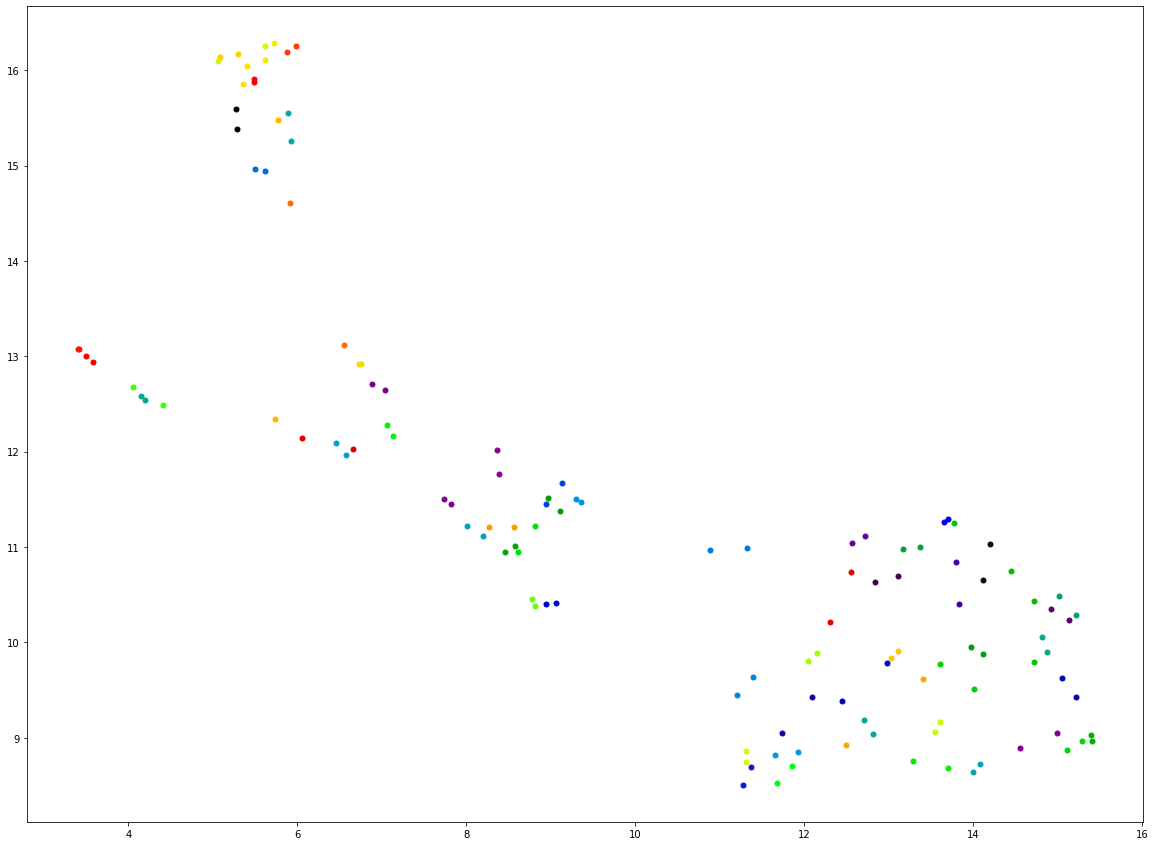

In [ ]:
label_set = np.unique(df_val['label'].values)
num_classes = len(label_set)
plt.figure(figsize=(20, 15))
plt.gca().set_prop_cycle(
    cycler(
        "color", [plt.cm.nipy_spectral(i) for i in np.linspace(0, 0.9, num_classes)]
    )
)
for i in range(num_classes):
  idx = train[train['label'] == label_set[i]].index.values
  #print(idx)
  plt.plot(umap_embeddings[idx, 0], umap_embeddings[idx, 1], ".", markersize=10)
plt.show()

In [ ]:
print(list(ViTExtractor.pretrained_models.keys()))

['vits16_dino', 'vits8_dino', 'vitb16_dino', 'vitb8_dino', 'vits16_inshop', 'vits16_sop', 'vits16_cub', 'vits16_cars']
